# Mount drive

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
cd /content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work

/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work


In [ ]:
!pip install rasterio rasterstats fiona geopandas

     |████████████████████████████████| 19.3 MB 379 kB/s 
     |████████████████████████████████| 16.7 MB 490 kB/s 
     |████████████████████████████████| 1.0 MB 45.1 MB/s 
     |████████████████████████████████| 130 kB 57.0 MB/s 
     |████████████████████████████████| 6.3 MB 48.9 MB/s 


In [ ]:
#import required libraries
import rasterio
import pylab
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import osr
import ogr
import gdal
import glob
from shapely.geometry import mapping
from rasterio.mask import mask
import numpy as np
import matplotlib
import math
import os
from rasterstats import zonal_stats
from datetime import datetime

In [ ]:
path = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work'
pathim = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana'

In [ ]:
#==========================================================================
#==========================================================================
# Specify the path of the images
mndwi_path = pathim + '/2021/mndwi'
boundary_path = path +'/data/boundaries/dagana2.geojson'
s2cloudless_path = pathim +'/2021/cloud'
reference_image_path =pathim+'/2021/mndwi/mndwi_2021-01-02.tif'
rgb_img = pathim+'/2021/rgb/mndwi_2022-01-02.tif'

# reference_s2cloudless_path =pathim+'/2021/cloud/cloud_2021-01-02.tif'

def is_image_good_to_work_with(reference_image_path, img_path, boundary_path):
  boolean = True
  count_ref_img = zonal_stats(boundary_path,reference_image_path)
  count_current_img = zonal_stats(boundary_path,img_path)
  ratio =count_ref_img[0]['count']/ count_current_img[0]['count']
  #if the number of pixels in the new image is 2 times less than the one in the reference image
  if ratio >2:
    boolean = False
  return boolean
def select_images(mndwi_path, boundary_path, reference_image_path =pathim+'/2021/mndwi/mndwi_2021-01-02.tif'):
  list_mndwi =  os.listdir(mndwi_path)
  selection_mndwi = []
  for img_name in list_mndwi:
    print(img_name)
    val = is_image_good_to_work_with(reference_image_path, mndwi_path +'/'+img_name, boundary_path)
    if val == True:
      # fill in with the image name at time x
      selection_mndwi.append(img_name)
  return selection_mndwi

def collect_images(boundary_path , mndwi_path, s2cloudless_path , reference_image_path =pathim+'/2021/mndwi/mndwi_2021-01-02.tif'):
  def sort_dates (dates_str, format='%Y-%m-%d'): 
    # Sort data
    dates_obj =[ datetime.strptime(date_time_str, format) for date_time_str in dates_str]
    #  sorteddates = [datetime.strftime(ts, format) for ts in dates_obj]
    dates_obj.sort()
    return dates_obj
    
  def check_if_date_in_(file,img_name):
    if file in img_name:
      return True
    else:
      return False
  res =  select_images(mndwi_path, boundary_path, reference_image_path)
  dates_str  =[ img_name.split('_') [1].split('.')[0] for img_name in res ]
  dates = sort_dates (dates_str, format='%Y-%m-%d')
  dates_str = [d.strftime("%Y-%m-%d") for d in dates  ]

  list_cloud =  os.listdir(s2cloudless_path)
  selection_ndwi={}
  selection_s2cloudless ={}
  for d in dates_str :
    selection_ndwi[d]= 'mndwi_'+d+'.tif'
    if 'cloud_'+ d + '.tif' in list_cloud :
      selection_s2cloudless[d] =   'cloud_'+ d + '.tif' 
    else: 
      selection_s2cloudless[d] =-1
  check_s2cloudless = [d  for d in selection_s2cloudless.keys() if selection_s2cloudless[d]==-1]
  print('==================== NUMBER OF IMAGES WITH NO CORRESPONDIND S2CLOUDLESS IMAGES  : ', len(check_s2cloudless ), 'DATES : ', check_s2cloudless )
  return selection_ndwi, selection_s2cloudless

In [ ]:
def init_array(rgb_array):
  working_array = rgb_array.copy()
  for i in range(0,rgb_array.shape[0]):
    for j in range(0,rgb_array.shape[1]):
      if rgb_array [i,j] > 0:
        working_array[i,j] = 1
      else:
        working_array[i,j] = 0
  return working_array

In [ ]:

mndwi_path = pathim + '/2020/mndwi'
boundary_path = path +'/data/boundaries/dagana2.geojson'
s2cloudless_path = pathim +'/2020/cloud'
reference_image_path = pathim+'/2021/mndwi/mndwi_2021-01-02.tif'
rgb_img = pathim+'/2021/rgb/rgb_2022-01-02.tif'


In [ ]:
list_mndwi =  os.listdir(mndwi_path)

In [ ]:
len(list_mndwi)

61

In [ ]:
list_mndwi

In [ ]:
#is_image_good_to_work_with(rgb_img, pathim+'/2021/mndwi/mndwi_2021-04-24.tif', boundary_path)

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


False

In [ ]:
rgb_array = rasterio.open(rgb_img).read(1)
r= init_array(rgb_array)

In [ ]:
selection_ndwi, selection_s2cloudless = collect_images(boundary_path , mndwi_path, s2cloudless_path ,rgb_img)
listimg =[]
listcloud=[]
for d in selection_ndwi.keys():
  listimg.append(selection_ndwi[d])
  listcloud.append(selection_s2cloudless[d])

In [ ]:
listcloud

In [ ]:
# listcloud = ['cloud_2019-12-29.tif',
#  'cloud_2020-01-03.tif',
#  'cloud_2020-01-08.tif',
#  'cloud_2020-01-13.tif',
#  'cloud_2020-01-18.tif',
#  'cloud_2020-01-23.tif',
#  'cloud_2020-01-28.tif',
#  'cloud_2020-02-02.tif',
#  'cloud_2020-02-07.tif',
#  'cloud_2020-02-12.tif',
#  'cloud_2020-02-17.tif',
#  'cloud_2020-02-22.tif',
#  'cloud_2020-02-27.tif',
#  'cloud_2020-03-03.tif',
#  'cloud_2020-03-08.tif',
#  'cloud_2020-03-13.tif',
#  'cloud_2020-03-18.tif',
#  'cloud_2020-03-23.tif',
#  'cloud_2020-03-28.tif',
#  'cloud_2020-04-02.tif',
#  'cloud_2020-04-07.tif',
#  'cloud_2020-04-12.tif',
#  'cloud_2020-04-17.tif',
#  'cloud_2020-04-22.tif',
#  'cloud_2020-04-27.tif',
#  'cloud_2020-05-02.tif',
#  'cloud_2020-05-07.tif',
#  'cloud_2020-05-12.tif',
#  'cloud_2020-05-17.tif',
#  'cloud_2020-05-22.tif',
#  'cloud_2020-05-27.tif']

In [ ]:
len (listimg)

31

In [ ]:
rgb_array = rasterio.open(rgb_img).read(1)
r= init_array(rgb_array)

In [ ]:
r = rasterio.open(pathim+'/2021/output/maps/test.tif').read(1)

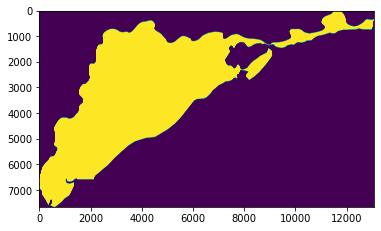

In [ ]:
plot.show(r)

In [ ]:
arrayimgcopy = r.copy()
arraycloud =r.copy()
arrayimg3copy = r.copy()

In [ ]:
arrayimg1 =  arrayimgcopy.copy()
arrayimg11 =  arrayimgcopy.copy()
arrayimg12 =  arrayimgcopy.copy()
arrayimg13 =  arrayimgcopy.copy()
arrayimg14 =  arrayimgcopy.copy()
arraycloud1 = arrayimgcopy.copy()
arraycloud2 = arrayimgcopy.copy()
arrayimg15  = arrayimgcopy.copy()

arrayimg2 = arrayimgcopy.copy()
arraycloud  =  arrayimgcopy.copy()
arraytotalcloud  =  arrayimgcopy.copy()
arrayimg3 = arrayimg3copy.copy()
# # listimg = dfimg['image_name'].unique().tolist()
# # listrgb = dfrgb['image_name'].unique().tolist()
# # listcloud = dfcloud['image_name'].unique().tolist()
# listimg = ['mndwi_2022-01-02.tif','mndwi_2022-01-07.tif','mndwi_2022-01-12.tif','mndwi_2022-01-17.tif','mndwi_2022-01-22.tif', 'mndwi_2022-01-27.tif']
# listrgb = ['rgb_2022-01-02.tif','rgb_2022-01-07.tif','rgb_2022-01-12.tif','rgb_2022-01-17.tif','rgb_2022-01-22.tif','rgb_2022-01-27.tif']
# listcloud = ['cloud_2022-01-02.tif', 'cloud_2022-01-07.tif', 'cloud_2022-01-12.tif', 'cloud_2022-01-17.tif','cloud_2022-01-22.tif','cloud_2022-01-27.tif']

pix = 2
q = 2
inc =0
fill = 2
fill2=3
fillneg = 13
#arr_res1 =  #rasterio.open(path+'/Results/'+listimg[0], driver='Gtiff').read(1)
#arr_res = rasterio.open(path+'/'+listimg[0], driver='Gtiff').read(1)
while inc < len(listimg) :
  g = listimg[inc]
  h =  listcloud[inc] #listrgb[inc]
  if h!=-1:  # Soit tu utilises l image telquell, soit tu la   : Ca doit etre exceptionele
    print("---------- FIRST TRY ----------------")
    print(inc)
    print("---------- END TRY ----------------")

    im1 =  rasterio.open(mndwi_path +'/' +g, driver='Gtiff').read(1)
    # im2 =  rasterio.open(path+'/rgb_img/'+h, driver='Gtiff').read(1)
    im2 =  rasterio.open(s2cloudless_path+'/'+h, driver='Gtiff').read(1)

    for i in range(0,im1.shape[0]):
      for j in range(0,im1.shape[1]):
        # if im2 [i,j] == 255:
        #   arraytotalcloud[i,j] = q
        if q > 3:
          if  arrayimg1[i-1,j-1] == q-1 :
              if im1[i,j] <=0:
                arrayimg11 [i,j]= 5 
                arraycloud1 [i-1,j-1] = pix
                arrayimg1 [i-1,j-1] = 1

          if  arrayimg12[i-1,j-1] == q-1 :
              if im1[i,j] <=0:
                arraycloud2 [i-1,j-1] = pix
                arrayimg12 [i-1,j-1] =  1    # just here  # Probaby the best one
        if q > 2:
          if  arrayimg1[i-1,j-1] == q-1 :
              if im1[i,j] <=0:
                arrayimg15 [i,j]= 1
  
        if (im1[i,j] > 0)  : # Water is detected

          if arrayimg1[i,j] ==1: # The pixel is not yet filled
          # ----------------------CASE 1   
            if q == 2:
                  arrayimg1[i,j] = q
                  # arrayimg13 [i,j] =  q  # just here
            else :
              # if cloud 
              if im2 [i,j] < 40 : #== 255:
                arrayimg1[i,j] = q
                # arrayimg12 [i,j] = q  

           # CASE 2===================================               
          if arrayimg12[i,j] ==1: # The pixel is not yet filled
              # if cloud 
              if im2 [i,j] < 40 : #== 255:
                arrayimg12 [i,j] = q

           # CASE 3===================================               
          if arrayimg13[i,j] ==1: # The pixel is not yet filled  ONLY HERE
          # skip water img
            if q == 2:
                  arrayimg13[i,j] = 2
                  # arrayimg13 [i,j] =  q  # just here
            else :
              # if cloud 
              if im2 [i,j] < 40 : #== 255:
                # arrayimg1[i,j] = q
                arrayimg13 [i,j] = q
        
          # CASE 4===================================               No condition here 
          if arrayimg14[i,j] ==1: # The pixel is not yet filled
              # if cloud 
              if im2 [i,j] < 40 : #== 255:
                # arrayimg1[i,j] = q
                arrayimg14 [i,j] = q
            
          # # CASE 4===================================               No condition here 
          # if arrayimg15[i,j] ==1: # The pixel is not yet filled
          #     # if cloud 
          #     if im2 [i,j] < 40 : #== 255:
          #       # arrayimg1[i,j] = q
          #       arrayimg15 [i,j] = q


  
      
  




    q = q+1
    inc +=1
    pix +=1


  #====================compute res =========================

---------- FIRST TRY ----------------
0
---------- END TRY ----------------
---------- FIRST TRY ----------------
1
---------- END TRY ----------------
---------- FIRST TRY ----------------
2
---------- END TRY ----------------
---------- FIRST TRY ----------------
3
---------- END TRY ----------------
---------- FIRST TRY ----------------
4
---------- END TRY ----------------
---------- FIRST TRY ----------------
5
---------- END TRY ----------------
---------- FIRST TRY ----------------
6
---------- END TRY ----------------
---------- FIRST TRY ----------------
7
---------- END TRY ----------------
---------- FIRST TRY ----------------
8
---------- END TRY ----------------
---------- FIRST TRY ----------------
9
---------- END TRY ----------------
---------- FIRST TRY ----------------
10
---------- END TRY ----------------
---------- FIRST TRY ----------------
11
---------- END TRY ----------------
---------- FIRST TRY ----------------
12
---------- END TRY ----------------
---------

In [ ]:
# profile = rasterio.open(reference_image_path, driver='Gtiff').profile
# with rasterio.open(pathim+'/2020/output/maps/flooding_maps2020_1.tif', 'w', **profile) as dst:
#         dst.write(arrayimg1.astype(rasterio.uint8), 1)


# profile = rasterio.open(reference_image_path, driver='Gtiff').profile
# with rasterio.open(pathim+'/2020/output/maps/flooding_maps2020_12.tif', 'w', **profile) as dst:
#         dst.write(arrayimg12.astype(rasterio.uint8), 1)

# profile = rasterio.open(reference_image_path, driver='Gtiff').profile
# with rasterio.open(pathim+'/2020/output/maps/flooding_maps2020_13.tif', 'w', **profile) as dst:
#         dst.write(arrayimg13.astype(rasterio.uint8), 1)   

profile = rasterio.open(reference_image_path, driver='Gtiff').profile
with rasterio.open(pathim+'/2020/output/maps/flooding_maps2020_14.tif', 'w', **profile) as dst:
        dst.write(arrayimg14.astype(rasterio.uint8), 1)  

# profile = rasterio.open(reference_image_path, driver='Gtiff').profile
# with rasterio.open(pathim+'/2020/output/maps/cloud_surplus.tif', 'w', **profile) as dst:
#         dst.write(arraycloud1.astype(rasterio.uint8), 1)    

# profile = rasterio.open(reference_image_path, driver='Gtiff').profile
# with rasterio.open(pathim+'/2020/output/maps/cloud_surplus2.tif', 'w', **profile) as dst:
#         dst.write(arraycloud2.astype(rasterio.uint8), 1)                  

In [ ]:
#=== 14
res_set3 = list(set(i for j in arrayimg14 for i in j))
area =[]
val={}
for w in res_set3:
    x = arrayimg14[arrayimg14== w]
    #print('---------------')
    #print(w)
    #print(x.size)
    l= x.size*100*0.0001
    area.append(l)
    val[w] = l

    #print(l)
val

{0.0: 724416.54,
 1.0: 227754.59,
 2.0: 11914.050000000001,
 3.0: 2325.13,
 4.0: 1289.77,
 5.0: 1233.42,
 6.0: 419.65000000000003,
 7.0: 126.32000000000001,
 8.0: 266.05,
 9.0: 745.12,
 10.0: 588.75,
 11.0: 320.67,
 12.0: 125.74000000000001,
 13.0: 4102.54,
 14.0: 3960.13,
 15.0: 2665.26,
 16.0: 2111.17,
 17.0: 3514.2400000000002,
 18.0: 3177.31,
 19.0: 2445.44,
 20.0: 4.58,
 21.0: 5239.34,
 22.0: 915.7700000000001,
 23.0: 168.77,
 24.0: 93.08,
 25.0: 481.94,
 26.0: 318.93,
 27.0: 17.76,
 28.0: 213.17000000000002,
 29.0: 22.220000000000002,
 30.0: 97.0,
 31.0: 52.59,
 32.0: 34.96}

In [ ]:
sum(area) - area[0]-area[1] -area[2]

37076.82000000008